In [36]:
import fastf1 as ff1
from fastf1 import plotting
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import cm
import numpy as np
import pandas as pd

plotting.setup_mpl()
matplotlib.rcParams["figure.dpi"] = 600

In [37]:
# Pick the Grand Prix
year = 2024
gp = 'Bahrain'

# Pick the type of session. Options: FP1', 'FP2', 'FP3', 'Q', 'S', 'SS', and 'R'.
session = 'Q'

# Pick the drivers to show
drivers = ['VER', 'LEC', 'PER']

# Pick the number of minisectors
num_minisectors = 50

In [38]:
session_event = ff1.get_session(year, gp, session)
session_event.load()

core           INFO 	Loading data for Bahrain Grand Prix - Qualifying [v3.3.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '63', '55', '11', '14', '4', '81', '44', '27', '22', '18', '23', '3', '20', '77', '24', '2', '31', '10']


In [39]:
compare_drivers = session_event.laps[session_event.laps['Driver'].isin(drivers)]

In [40]:
# Get fastest laps for each driver
fastest_laps = [session_event.laps.pick_driver(driver).pick_fastest() for driver in drivers]

# Get telemetry for each driver
telemetry = [fastest_lap_driver.get_telemetry().add_distance() for fastest_lap_driver in fastest_laps]

for i, driver in enumerate(drivers):
    telemetry[i]['Driver'] = driver

joined_telemetry = pd.concat([tel for tel in telemetry])

core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.


In [41]:
total_distance = max(joined_telemetry['Distance'])
minisector_length = total_distance / num_minisectors
minisectors = [0]

for i in range(0, num_minisectors - 1):
    minisectors.append(minisector_length * (i + 1))

joined_telemetry['Minisector'] = joined_telemetry['Distance'].apply(lambda distance: (int((distance // minisector_length) + 1)))

average_speed = joined_telemetry.groupby(['Minisector', 'Driver'])['Speed'].mean().reset_index()

In [42]:
fastest_driver = average_speed.loc[average_speed.groupby(['Minisector'])['Speed'].idxmax()]
fastest_driver = fastest_driver[['Minisector', 'Driver']].rename(columns={'Driver': 'Fastest_driver'})

In [43]:
joined_telemetry = joined_telemetry.merge(fastest_driver, on=['Minisector'])
joined_telemetry = joined_telemetry.sort_values(by=['Distance'])

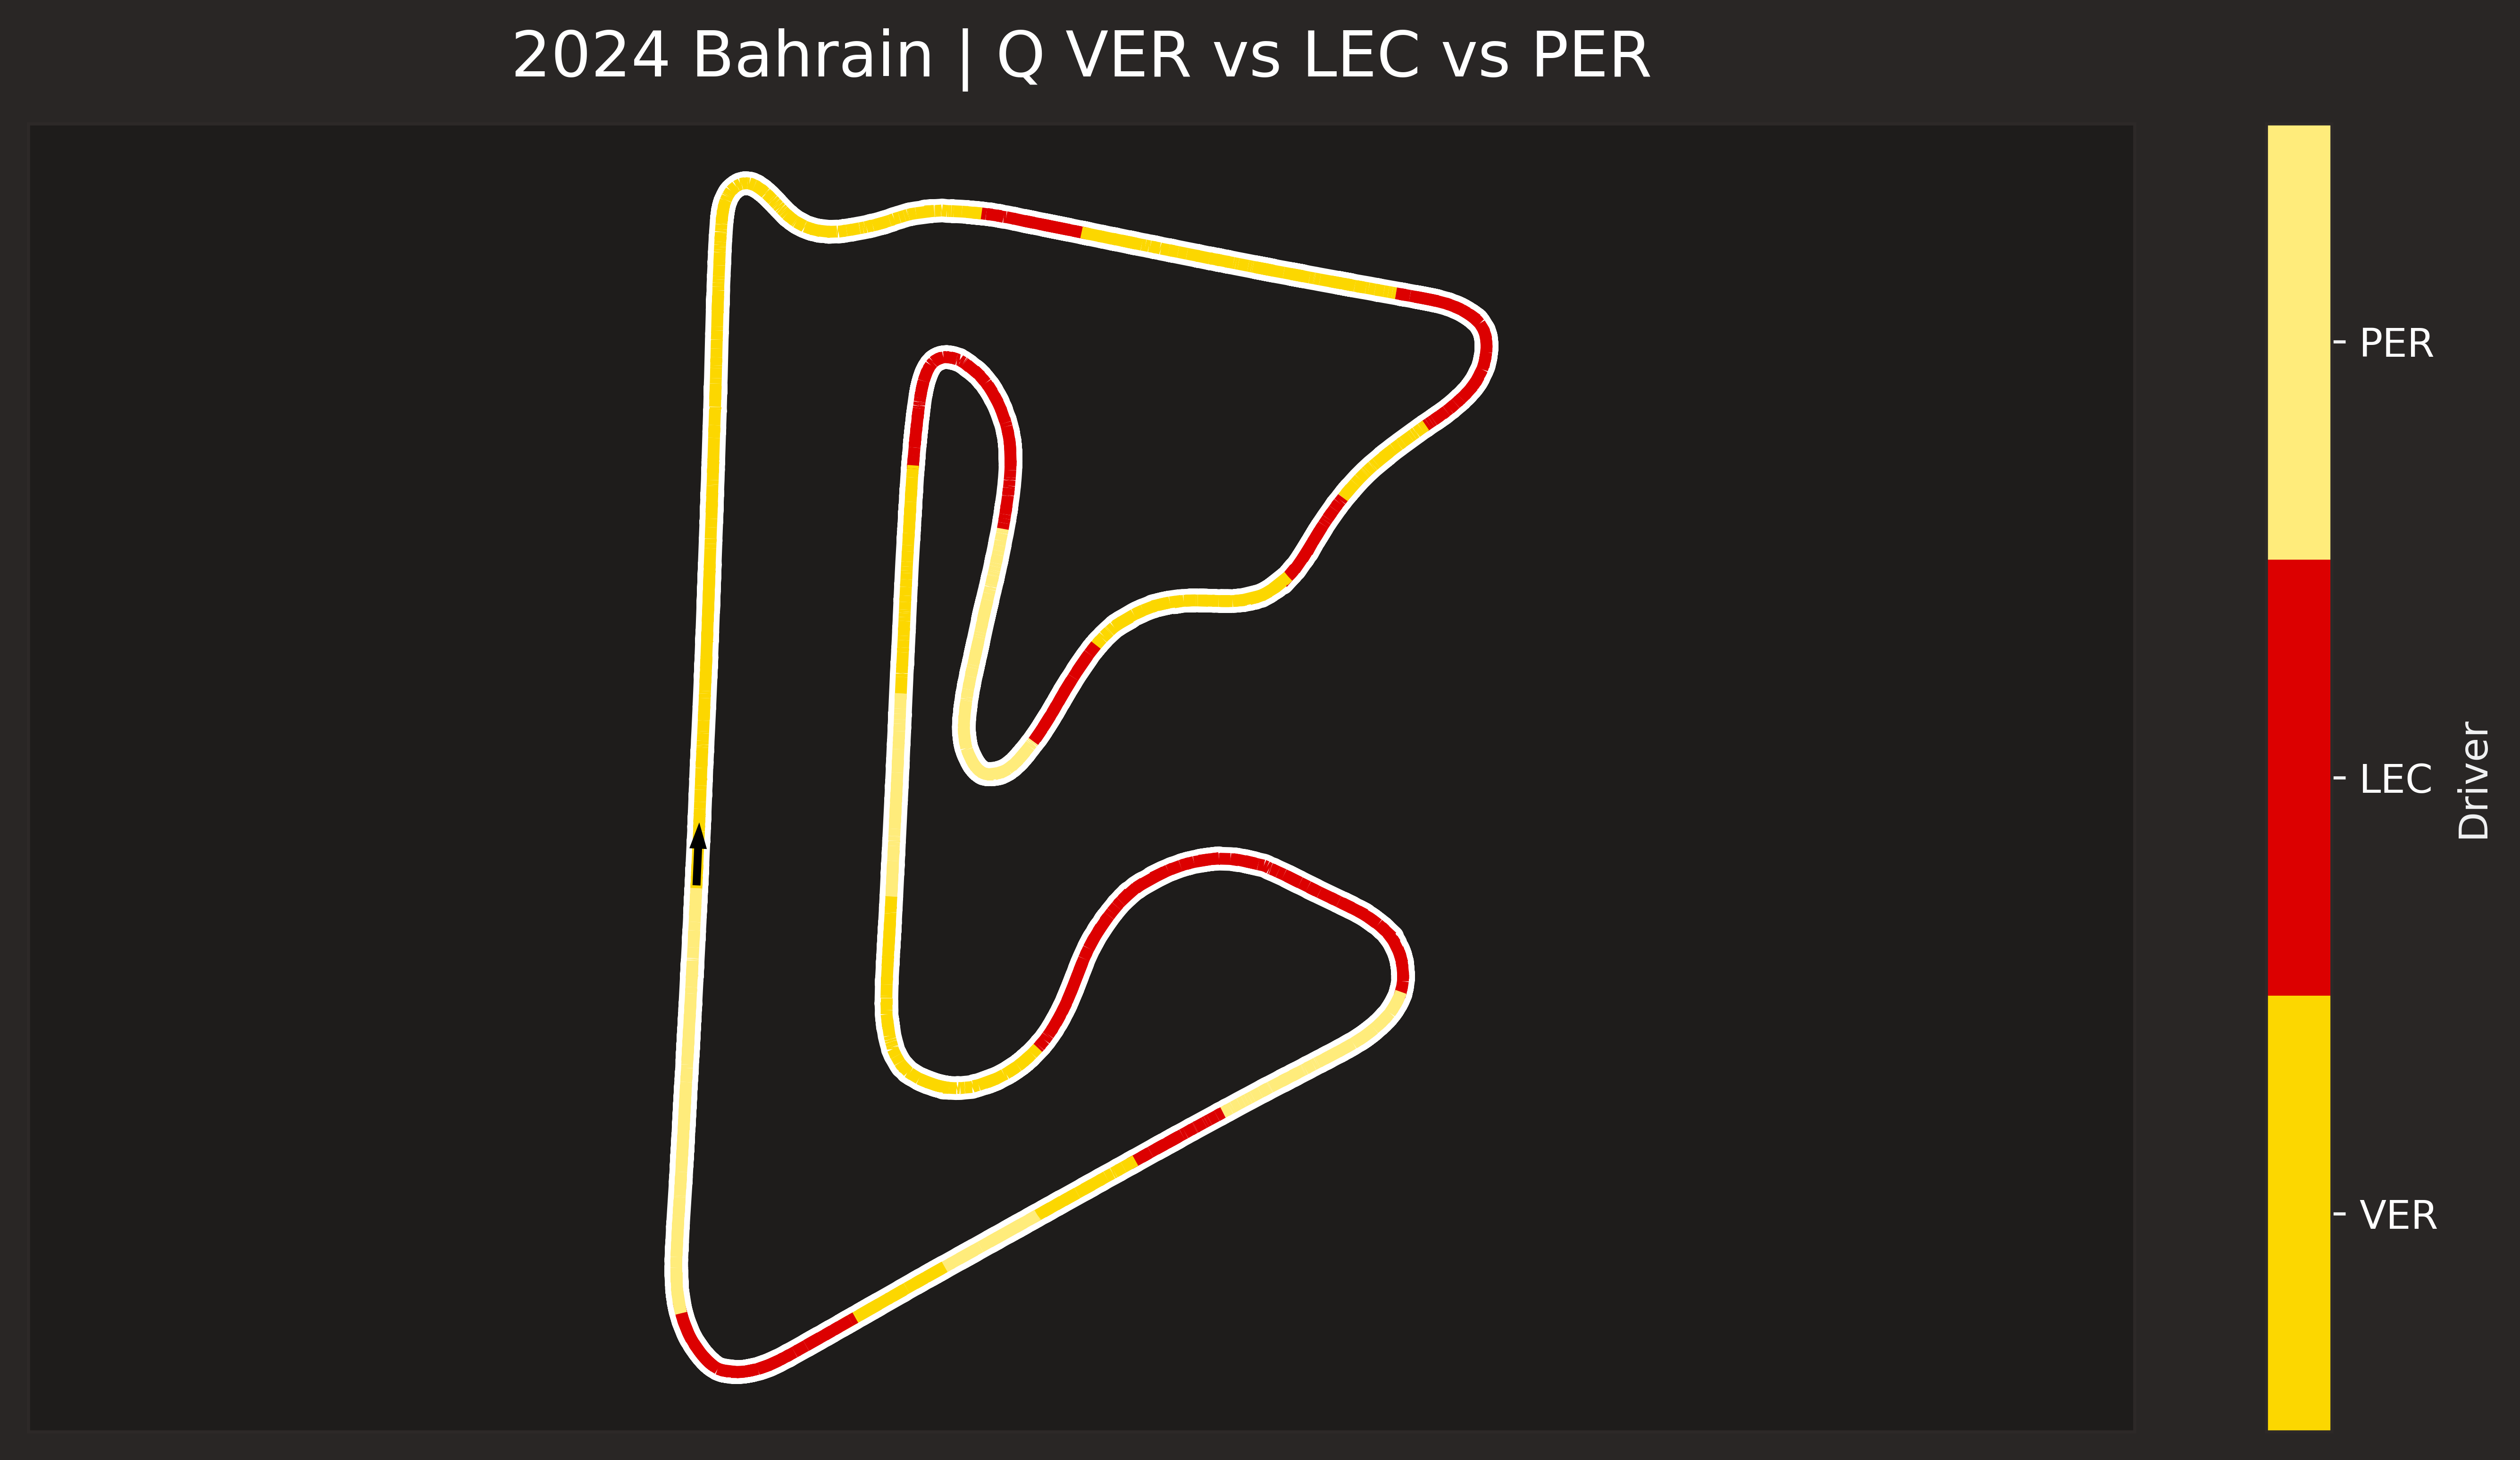

In [44]:
for i, driver in enumerate(drivers):
    joined_telemetry.loc[joined_telemetry['Fastest_driver'] == driver, 'Fastest_driver_int'] = int(i + 1)

x = np.array(joined_telemetry['X'].values)
y = np.array(joined_telemetry['Y'].values)

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
fastest_driver_array = joined_telemetry['Fastest_driver_int'].to_numpy().astype(float)

plt.plot(joined_telemetry['X'], joined_telemetry['Y'],
        color='white', linestyle='-', linewidth=6, zorder=0)

cmap = cm.colors.ListedColormap([f'{plotting.driver_color(driver)}' for driver in drivers])
lc_comp = LineCollection(segments, norm=plt.Normalize(1, cmap.N+1), cmap=cmap, linestyle='-')
lc_comp.set_array(fastest_driver_array)
lc_comp.set_linewidth(3)
lc_comp.set_antialiased(True)
lc_comp.set_linestyle

plt.rcParams['figure.figsize'] = [12, 6]

plt.gca().add_collection(lc_comp)
plt.axis('equal')
plt.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)

cbar = plt.colorbar(mappable=lc_comp, label='Driver', boundaries=np.arange(1,len(drivers) + 2))
cbar.set_ticks(np.arange(1.5, len(drivers) + 1.5))
cbar.set_ticklabels(drivers, color='white')

title_color = 'white'
plt.title(f"{year} {gp} | {session} {' vs '.join(drivers)}", color=title_color, fontsize = 16)

plt.arrow(joined_telemetry["X"][0], joined_telemetry["Y"][0], joined_telemetry["X"][5] - joined_telemetry["X"][0], joined_telemetry["Y"][5] - joined_telemetry["Y"][0], width=40, color='black', zorder=100)
plt.show()